In [1]:
import os
import glob
import pathlib

import xml.etree.ElementTree as et
from xml.dom import minidom

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras

from PIL import Image

import shap
import random

from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, plot_roc_curve, plot_confusion_matrix
import xgboost as xgb

import random
import matplotlib.cm as cm
from matplotlib.image import imread

np.random.seed(42)

from matplotlib import style
style.use('seaborn-pastel')

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


Set path to access dataset

In [2]:
data_dir = './sgtraffic'
train_path = './sgtraffic/Train'
test_path = './sgtraffic/Test'

In [3]:
filenames = next(os.walk(train_path))

In [4]:
file_paths = []
folder_paths = []

# get files and dir
for root, directories, files in os.walk(train_path):
    for filename in files:
        filepath = os.path.join(root, filename)
        folder_paths.append(root)
        file_paths.append(filepath)

In [5]:
pd.DataFrame(folder_paths).to_csv('./sgtraffic/folder.csv')
pd.DataFrame(file_paths).to_csv('./sgtraffic/files.csv')

Controlling the image at fixed image size to improve computing

In [6]:
img_ht = 50
img_wd = 50
channels = 3

Understanding classes

In [7]:
cat = len(os.listdir(train_path))
cat

32

In [8]:
classes = {
0:"INFO_END_OF_EXP_WAY",
1:"PROHIBITORY_NO_JAYWALKING",
2:"INFO_TP_CAMERA_ZONE",
3:"PROHIBITORY_SPD_LIMIT_90",
4:"MANDATORY_TURN_LEFT",
5:"WARNING_ERP",
6:"PROHIBITORY_SPD_LIMIT_70",
7:"INFO_U_TURN_LANE",
8:"MANDATORY_SPLIT_WAY",
9:"MANDATORY_STOP",
10:"PROHIBITORY_SPD_LIMIT_50",
11:"WARNING_CURVE_RIGHT_ALIGNMENT_MARKER",
12:"INFO_ZEBRA_CROSSING",
13:"INFO_RAIN_SHELTER",
14:"PROHIBITORY_NO_ENTRY",
15:"MANDATORY_KEEP_LEFT",
16:"INFO_PARKING_AREA_FOR_MOTORCARS",
17:"INFO_PEDESTRIAN_USE_CROSSING",
18:"WARNING_RESTRICTED_ZONE_AHEAD",
19:"WARNING_CURVE_LEFT_ALIGNMENT_MARKER",
20:"INFO_START_OF_EXP_WAY",
21:"MANDATORY_GIVE_WAY",
22:"PROHIBITORY_NO_VEH_OVER_HEIGHT_4.5",
23:"PROHIBITORY_SPD_LIMIT_40",
24:"WARNING_SLOW_SPEED",
25:"WARNING_ROAD_HUMP",
26:"PROHIBITORY_NO_LEFT_TURN",
27:"INFO_ONE_WAY_RIGHT",
28:"INFO_ONE_WAY_LEFT",
29:"WARNING_SLOW_DOWN",
30:"WARNING_MERGE",
31:"PROHIBITORY_NO_RIGHT_TURN"
}

In [9]:
signs_class = pd.DataFrame(classes, index = classes.keys()).head(1).T.reset_index()

In [10]:
signs_class.to_csv('./data/classes.csv')

Initialize lists

In [11]:
train_num = []
class_num = []

File path

In [12]:
folders = os.listdir(train_path)

In [13]:
for folder in folders:
    train_class = os.listdir(train_path + '/' + folder)
    train_num.append(len(train_class))
    class_num.append(classes[int(folder)])

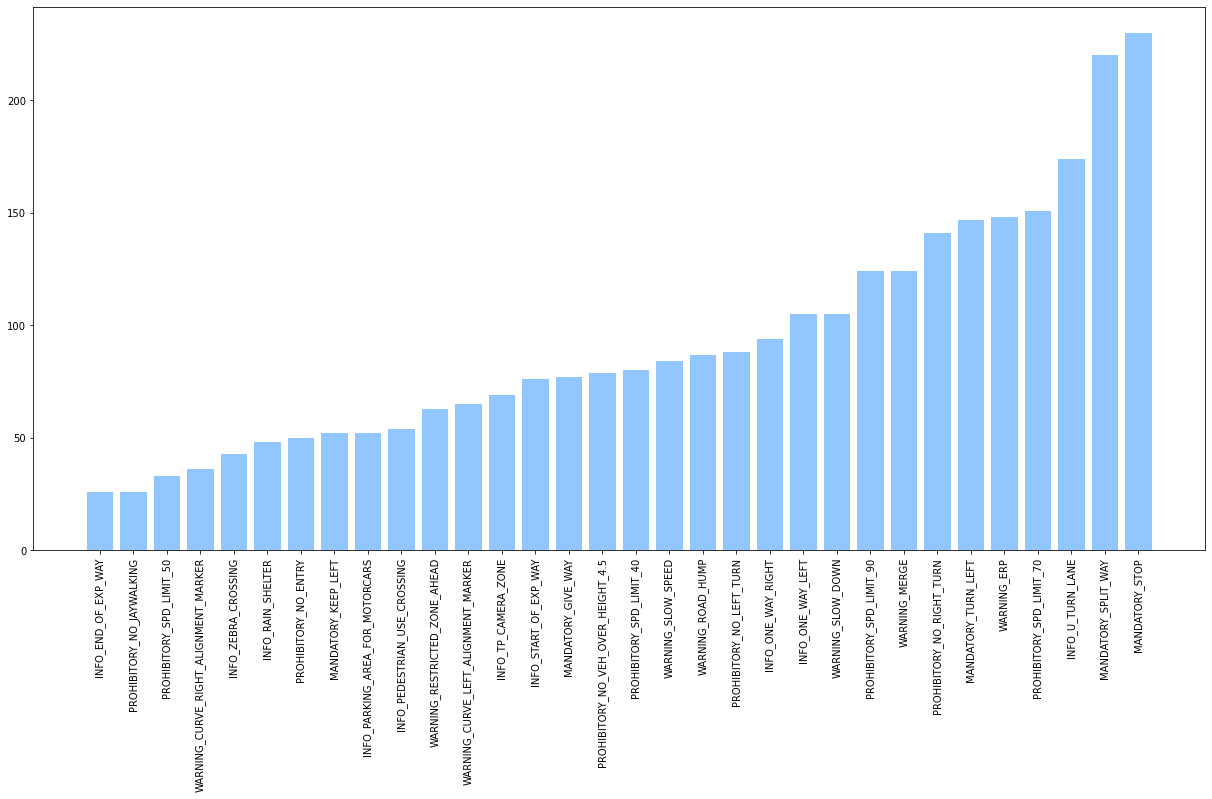

In [14]:
plt.figure(figsize=(21,10))  
plt.bar(class_num, sorted(train_num))
plt.xticks(class_num, rotation='vertical')
plt.show()

Resizing train data

In [15]:
image_data = []
image_labels = []

## check file paths
for i in range(cat):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)
    if i < 2:
        print(path, images)

./sgtraffic/Train/0 ['0356.jpg', '0357.jpg', '0457.jpg', '0460.jpg', '0463.jpg', '0466.jpg', '0470.jpg', '1562.jpg', '1566.jpg', '1570.jpg', '1683.jpg', '1689.jpg', '1699.jpg', '1719.jpg', '1722.jpg', '1727.jpg', '1730.jpg', '1784.jpg', '1956.jpg', '2044.jpg', '2047.jpg', '2050.jpg', '2196.jpg', '2199.jpg', '2284.jpg', '2287.jpg', '2303.jpg', '2603.jpg', '2606.jpg', '2678.jpg', '2680.jpg', '2681.jpg', '2682.jpg', '2691.jpg', '3635.jpg', '3638.jpg', '3641.jpg', '3644.jpg', '3647.jpg', '3650.jpg', '3653.jpg', '3656.jpg', '3658.jpg', '3660.jpg', '3662.jpg', '3664.jpg', '3666.jpg', '4599.JPG', '5110.jpg', '5123.jpg', '5259.jpg', '5277.jpg', '5340.jpg', '5343.jpg', '5414.jpg', '5417.jpg', '5420.jpg', '5422.jpg', '5544.JPG', '6116.jpg', '6117.jpg', '6675.JPG', '9455.JPG']
./sgtraffic/Train/1 ['0272.jpg', '0283.jpg', '0285.jpg', '0286.jpg', '0397.jpg', '0774.jpg', '0776.jpg', '0778.jpg', '0780.jpg', '0968.jpg', '0970.jpg', '1162.jpg', '1164.jpg', '1166.jpg', '1168.jpg', '2365.jpg', '2367.jpg'

Accessing images in folders

In [16]:
test_img = cv2.imread('./sgtraffic/Train/1' + '/' + '0780.jpg')

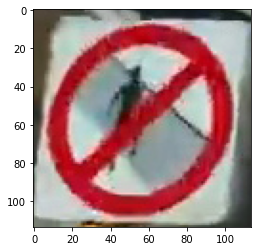

In [17]:
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB));

Appending numpy arrays images into image_data list

In [18]:
for i in range(cat):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB').resize((img_ht, img_wd))
            image_data.append(np.array(image_fromarray))
            image_labels.append(i)
        except:
            print(f'unable to process {path + img}')
        

unable to process ./sgtraffic/Train/21desktop.ini
unable to process ./sgtraffic/Train/26desktop.ini


In [19]:
image_data_array = np.array(image_data)
image_labels = np.array(image_labels)

In [20]:
image_data_array.shape

(2949, 50, 50, 3)

In [21]:
image_labels.shape

(2949,)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(image_data_array, image_labels, test_size=0.3, random_state=42, shuffle=True)

Preprocessing and preparing image pixel intensity range to be within 0-1.

In [23]:
X_train = X_train/255
X_test = X_test/255

Checking the shape of Train and Test data, to ensure it is the correct dimension with 3 channels

In [24]:
print(f'X train test shape {X_train.shape, X_test.shape}')

X train test shape ((2064, 50, 50, 3), (885, 50, 50, 3))


In [25]:
print(f'y train test shape {y_train.shape, y_test.shape}')

y train test shape ((2064,), (885,))


CCIR 601 standard rgb to grayscale weights

https://analyticsindiamag.com/a-beginners-guide-to-image-processing-using-numpy/

In [26]:
rgb_weights = [0.2989, 0.5870, 0.1140] ## rgb to bw conversion from CCIR 601

In [27]:
def rgb2bw(imgs):
    img_conv = []
    for img in imgs:
        grayscale_image = np.dot(img[...,:3], rgb_weights)
        img_conv.append(grayscale_image)
    img_conv_array = np.asarray(img_conv)
    return img_conv_array

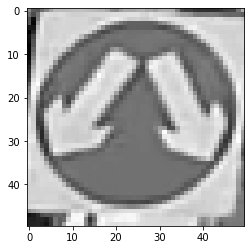

In [28]:
plt.imshow(rgb2bw(X_train[0]), cmap = 'gray'); ## add arg to display BW cmap = grey

In [29]:
train_gs = rgb2bw(X_train)
test_gs = rgb2bw(X_test)

In [30]:
train_gs.shape

(2064, 50, 50)

In [31]:
test_gs.shape

(885, 50, 50)

Reshape to 2d array

https://stackoverflow.com/questions/61573260/reshape-3d-numpy-array-of-images-to-2d-numpy-array-for-xgboost-dmatrix-input

Reshaping to 2D array is not the best method for fitting into XGBoost as the image loses some structure, but will be reshaping for baselining purpose using XGBoost.

In [32]:
train_gs_2d = train_gs.reshape(X_train.shape[0], (X_train.shape[1]*X_train.shape[2]))

In [33]:
train_gs_2d.shape

(2064, 2500)

In [34]:
test_gs_2d = test_gs.reshape(X_test.shape[0], (X_test.shape[1]*X_test.shape[2]))

In [35]:
test_gs_2d.shape

(885, 2500)

Modeling

CatBoost is extremely slow and ineffective for image classification

In [36]:
# cb_class = CatBoostClassifier()

In [37]:
# cb_class.fit(train_gs_2d, y_train)

XGBoost

XGBoost has a score of 0.84 but is very slow and ineffective too. Hence it wasnt included.

In [38]:
# xgb_class = xgb.XGBClassifier()

In [39]:
# xgb_params = {  'xgb__learning_rate': [0.1],
#                 'xgb__max_depth': [40],
#                 'xgb__min_child_weight': [25],
#                 'xgb__gamma': [0.85],
#                 'xgb__subsample': [1],
#                 'xgb__scale_pos_weight': [63],
#                 'xgb__n_estimators': [49]}

In [40]:
# xgb_class.fit(train_gs_2d, y_train)

In [41]:
# y_pred = xgb_class.predict(test_gs_2d)

In [42]:
# print(metrics.classification_report(y_test, y_pred))

#### Keras

One hot encoding

In [43]:
y_train = keras.utils.to_categorical(y_train, cat)
y_test = keras.utils.to_categorical(y_test, cat)

In [44]:
print(y_train.shape, y_test.shape)

(2064, 32) (885, 32)


After multiple trainings, it can be seen that there's a tendency for the model to overfit.

Parameters like rate decay according to epochs were used to attenuate the learning rate but dropped in the final training.
Dropout rate was explored to prevent overfit.

Creation of the functional model. THere is a need to fulfill the requirement of 2 simultaneous outputs of classification and localization.

After researching the Faster R-CNN architecture, we will first build the classification branch.

In [45]:
input_shape = (img_ht, img_wd, channels)
input_layer = tf.keras.layers.Input(input_shape)

In [46]:
bl = keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', name='bl1')(input_layer)
bl = keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='bl2')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl3')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl4')(bl)

bl = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='bl5')(bl)
bl = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='bl6')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl7')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl8')(bl)

bl = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', name='bl9')(bl)
bl = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu', name='bl10')(bl)
bl = keras.layers.MaxPool2D(pool_size=(2, 2), name='bl11')(bl)
bl = keras.layers.BatchNormalization(axis=-1, name='bl12')(bl)

bl = keras.layers.Flatten(name='bl13')(bl)

classifier_branch = keras.layers.Dense(1024, activation='relu', name='cl1')(bl)
classifier_branch = keras.layers.BatchNormalization(name='cl2')(bl)
classifier_branch = keras.layers.Dropout(rate=0.5, name='cl3')(bl)

classifier_branch = keras.layers.Dense(32, activation='softmax', name='cl_head')(classifier_branch)

In [47]:
model = tf.keras.Model(input_layer, outputs = [classifier_branch])

In [48]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 bl1 (Conv2D)                (None, 48, 48, 16)        448       
                                                                 
 bl2 (Conv2D)                (None, 46, 46, 32)        4640      
                                                                 
 bl3 (MaxPooling2D)          (None, 23, 23, 32)        0         
                                                                 
 bl4 (BatchNormalization)    (None, 23, 23, 32)        128       
                                                                 
 bl5 (Conv2D)                (None, 21, 21, 64)        18496     
                                                                 
 bl6 (Conv2D)                (None, 19, 19, 128)       73856 

In [49]:
lr = 0.001
epochs = 50

https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/

https://www.fast.ai/2018/07/02/adam-weight-decay/

https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

In [51]:
opt = Adam(learning_rate=lr, amsgrad=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [52]:
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='auto', verbose=1)

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator <br>

https://keras.io/api/preprocessing/image/ <br>

https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/ <br>

ImageDataGenerator is a concept of augmenting the image dataset by allowing the model to get variations of the images. <br>
It rotates, zoom, shifts image up and down and fills it with the nearest pixel to provide variations to the training data. <br>
Could be useful to generate more variations in the image dataset <br>

In [53]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [54]:
traffic_model = model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=epochs, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
65/65 [==============================] - 11s 168ms/step - loss: 1.4562 - accuracy: 0.6226 - val_loss: 3.7691 - val_accuracy: 0.0147
Epoch 2/50
65/65 [==============================] - 11s 162ms/step - loss: 0.4283 - accuracy: 0.8798 - val_loss: 4.1052 - val_accuracy: 0.1062
Epoch 3/50
65/65 [==============================] - 11s 165ms/step - loss: 0.2559 - accuracy: 0.9278 - val_loss: 4.0510 - val_accuracy: 0.1130
Epoch 4/50
65/65 [==============================] - 11s 162ms/step - loss: 0.1873 - accuracy: 0.9491 - val_loss: 4.3277 - val_accuracy: 0.1390
Epoch 5/50
65/65 [==============================] - 11s 166ms/step - loss: 0.1418 - accuracy: 0.9612 - val_loss: 4.3116 - val_accuracy: 0.0723
Epoch 6/50
65/65 [==============================] - 11s 168ms/step - loss: 0.1178 - accuracy: 0.9608 - val_loss: 2.5334 - val_accuracy: 0.3424
Epoch 7/50
65/65 [==============================] - 11s 169ms/step - loss: 0.1160 - accuracy: 0.9675 - val_loss: 0.8520 - val_accuracy: 0.7763

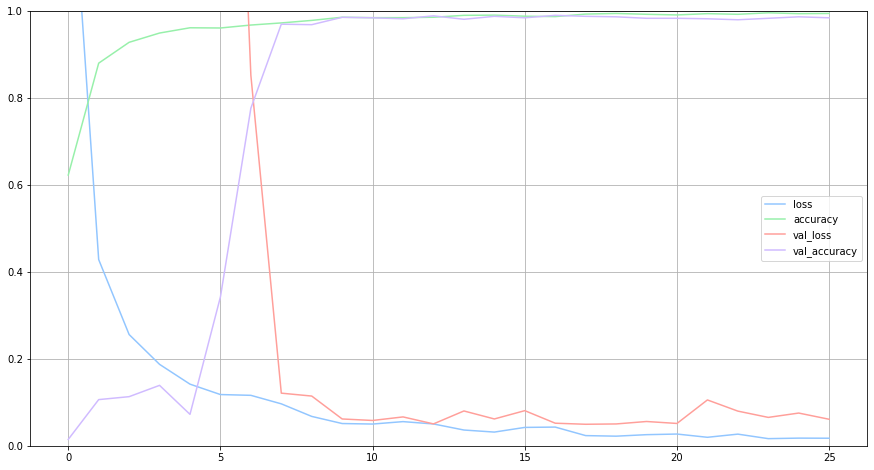

In [55]:
pd.DataFrame(traffic_model.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [56]:
test = pd.read_csv('./sgtraffic/Test.csv')

In [57]:
labels = test['ClassId'].values
imgs = test['Path'].values

In [58]:
test_data = []

In [59]:
for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' + img)
        image_fromarray = Image.fromarray(image, 'RGB').resize((img_ht, img_wd))
        test_data.append(np.array(image_fromarray))
    except:
        print(f'unable to process {path + img}')

In [60]:
X_test1 = np.array(test_data)

In [61]:
X_test1 = X_test1/255

In [62]:
pred = model.predict(X_test1)

In [63]:
classes_x = np.argmax(pred, axis=1)

In [64]:
classes_x

array([ 0,  0,  0,  0,  0,  0,  0, 18,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 11, 19, 19, 19, 24, 19,
       19, 19,  2,  2,  2,  2,  2,  2,  2,  2, 20, 20, 24, 20, 20, 20, 20,
       20, 20, 20, 24, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,  3, 23, 23, 23, 23, 23,
       23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27,
       27, 27, 27, 27, 27

In [65]:
print(f'Test data accuracy {accuracy_score(labels, classes_x)*100}')

Test data accuracy 95.17045454545455


In [66]:
print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.92      1.00      0.96        11
           2       1.00      1.00      1.00         8
           3       0.90      0.75      0.82        12
           4       1.00      1.00      1.00         8
           5       0.90      0.90      0.90        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        11
           8       1.00      0.93      0.96        14
           9       1.00      0.87      0.93        15
          10       1.00      1.00      1.00        13
          11       0.92      1.00      0.96        12
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        12
          16       1.00      1.00      1.00        11
          17       1.00    

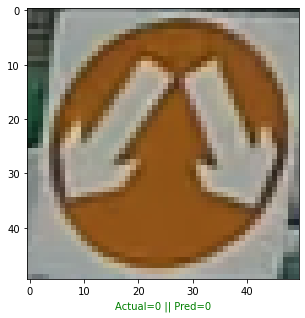

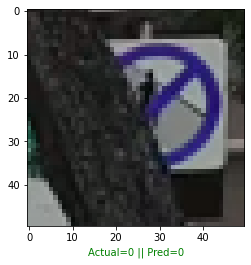

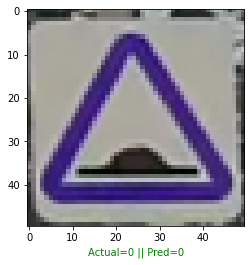

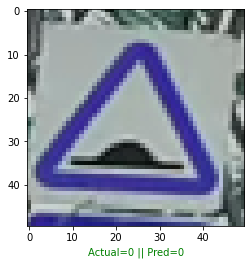

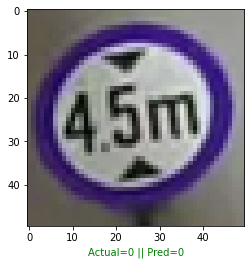

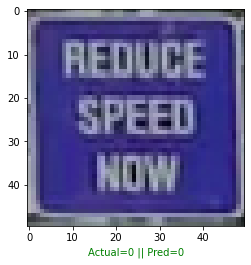

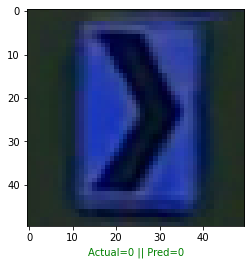

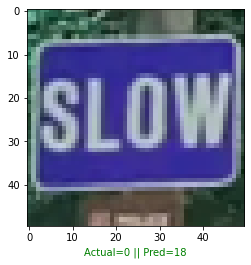

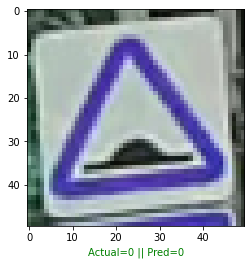

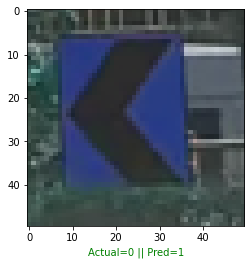

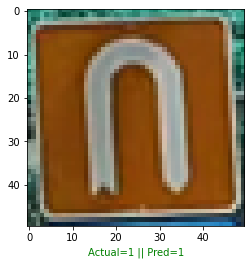

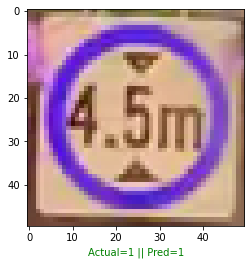

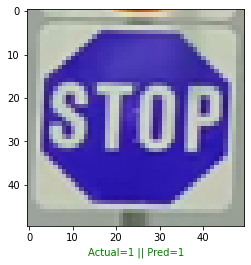

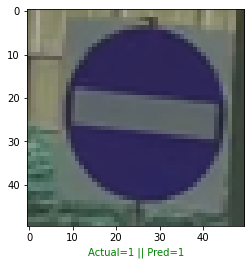

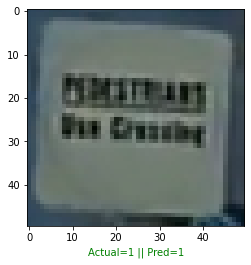

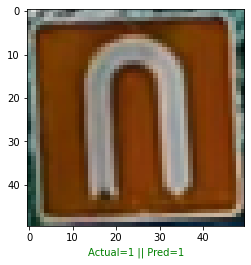

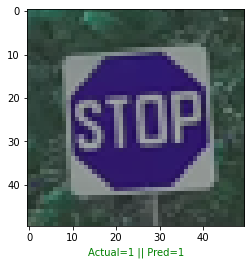

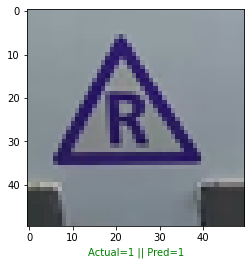

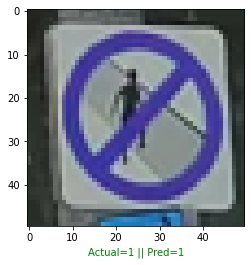

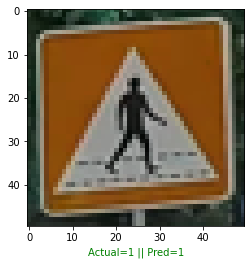

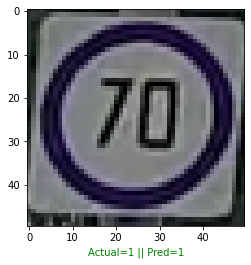

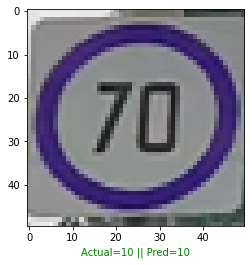

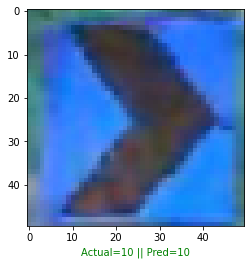

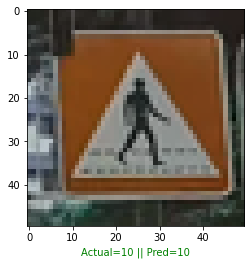

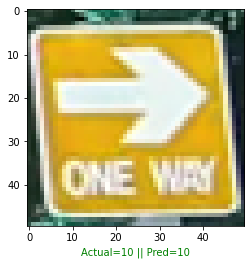

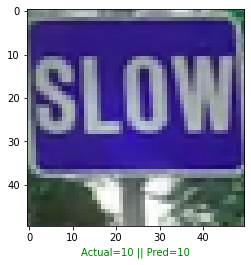

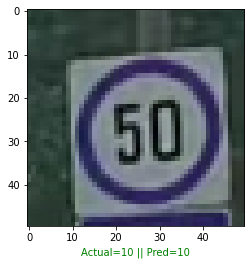

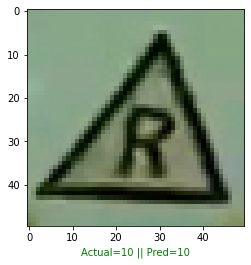

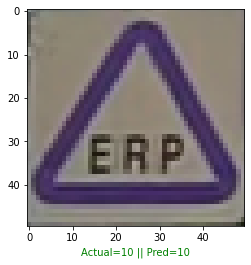

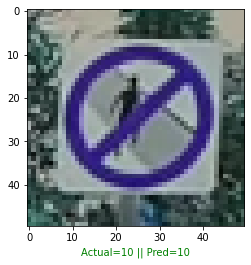

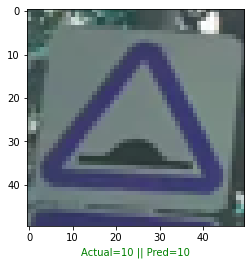

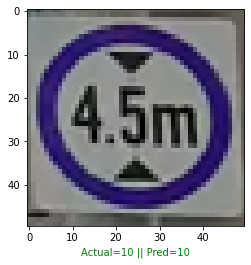

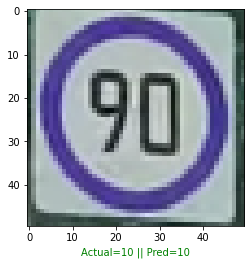

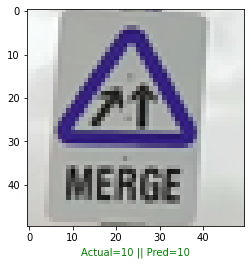

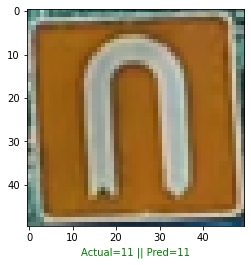

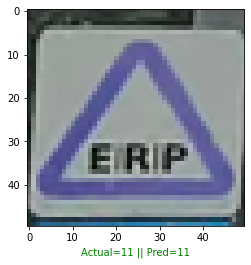

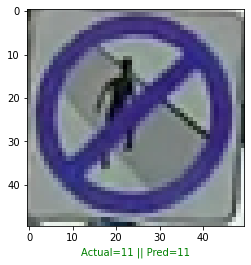

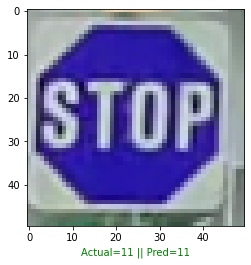

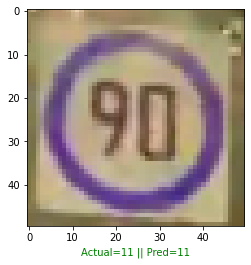

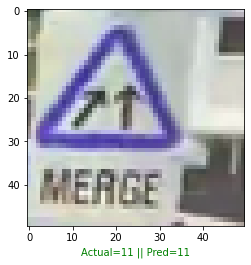

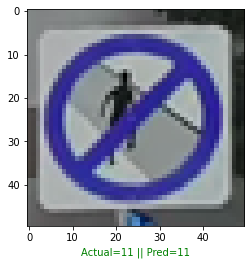

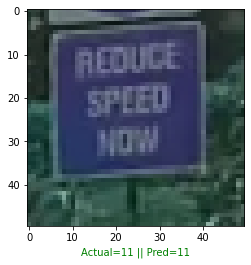

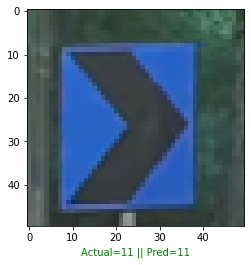

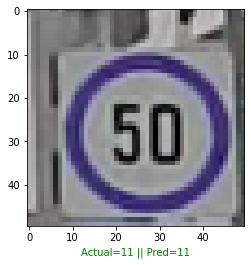

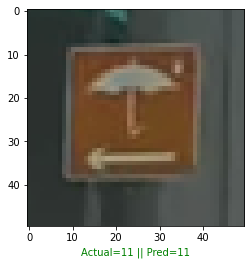

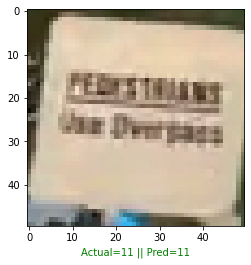

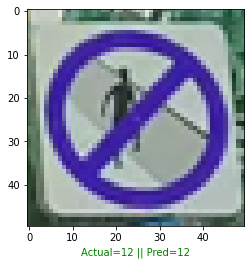

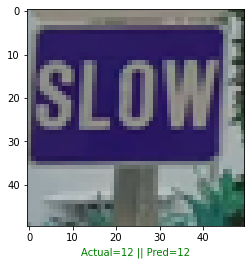

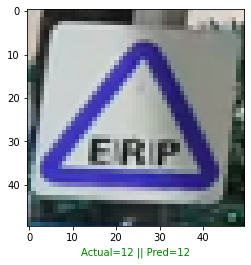

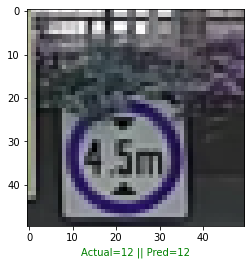

In [67]:
plt.figure(figsize = (5, 5))

for i in range(50):
    plt.xlabel(f'Actual={labels[i]} || Pred={classes_x[i]}', color= 'g')
    plt.imshow(X_test[i])
    plt.show()

In [68]:
model.save('./saved_models/sgtraffic/sg_traffic_signs.h5')

In [69]:
model.save_weights('./saved_models/sgtraffic/weights')

Model Interpretation

In [70]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [71]:
ex = X_test[99]

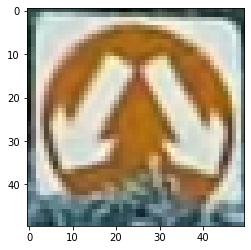

In [72]:
plt.imshow(ex);

GradCAM will help to interpret how the model interprets the features in the last convolution layer by creating a heatmap.

In [73]:
ex_dims = np.expand_dims(ex, axis=0)

In [74]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [75]:
heatmap = make_gradcam_heatmap(ex_dims, model, 'bl10')

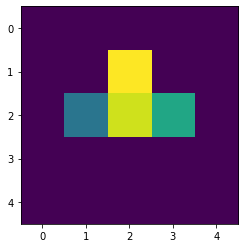

In [76]:
plt.imshow(heatmap);

In [77]:
plt.imsave('./imgs/ex1.jpg', heatmap)

In [78]:
heatmap = np.uint8(255 * heatmap)

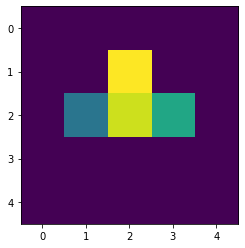

In [79]:
plt.imshow(heatmap);

In [80]:
jet = cm.get_cmap("jet")

In [81]:
jet_colors = jet(np.arange(256))[:, :3]

In [82]:
jet_heatmap = jet_colors[heatmap]

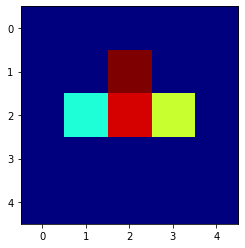

In [83]:
plt.imshow(jet_heatmap);

In [84]:
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((ex_dims.shape[1], ex_dims.shape[2]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

In [85]:
jet_heatmap.shape

(50, 50, 3)

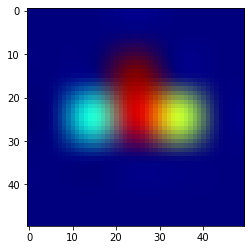

In [86]:
plt.imshow(jet_heatmap/255)

In [87]:
jet_heatmap = jet_heatmap / 255

In [88]:
alpha=0.4

In [89]:
superimposed_img = jet_heatmap * alpha + ex_dims

In [90]:
superimposed_img.shape

(1, 50, 50, 3)

In [91]:
test_img = ex_dims.reshape(img_ht, img_wd, 3)

In [92]:
superimposed_img_reshape = superimposed_img.reshape(img_ht, img_wd, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


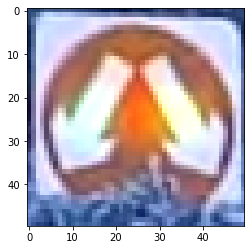

In [93]:
plt.imshow(superimposed_img_reshape);

Create function to display gradcam heatmap

In [94]:
def display_gradcam(val, model, lastconv, alpha):
    ex = X_test[val]
    ex_dims = np.expand_dims(ex, axis=0)

    heatmap = make_gradcam_heatmap(ex_dims, model, lastconv) #conv2d_5
    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]

    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((ex_dims.shape[1], ex_dims.shape[2]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    jet_heatmap = jet_heatmap / 255

    alpha=alpha
    superimposed_img = jet_heatmap * alpha + ex_dims
    superimposed_img_reshape = superimposed_img.reshape(X_test[val].shape[0], X_test[val].shape[1], channels)
    
    return plt.imshow(superimposed_img_reshape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


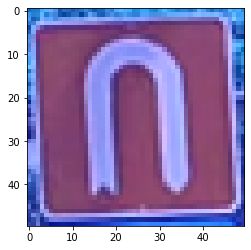

In [95]:
display_gradcam(10, model, 'bl10', 0.4)

In [96]:
img_shuffle = random.sample(range(0, len(X_test)), 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


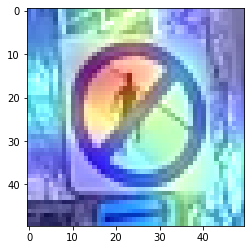

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


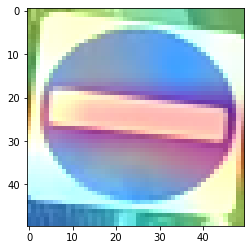

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


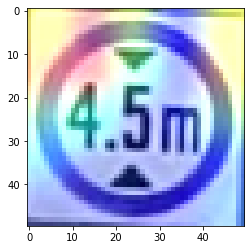

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


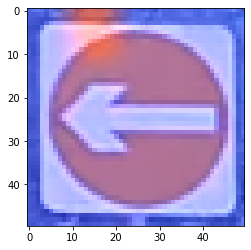

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


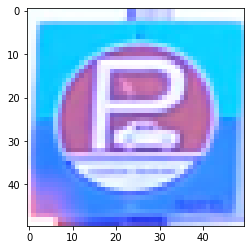

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


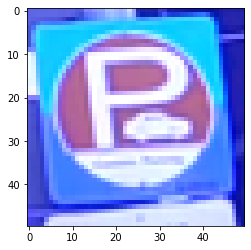

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


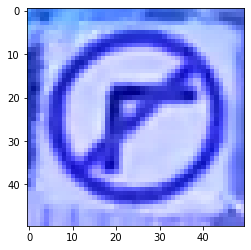

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


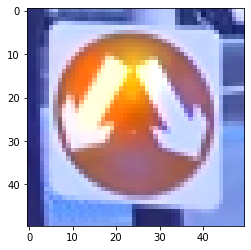

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


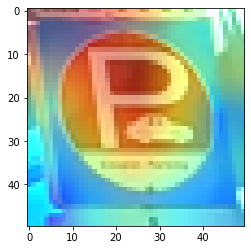

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


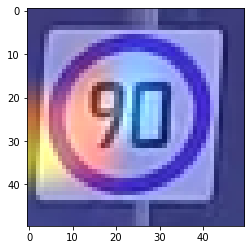

In [97]:
for i in img_shuffle:
    display_gradcam(i, model, 'bl10', 0.5)
    plt.show()

Understanding why the model predicts wrongly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


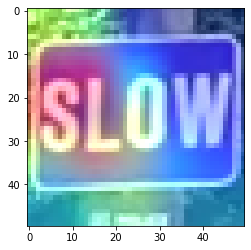

In [98]:
display_gradcam(7, model, 'bl10', 0.5)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


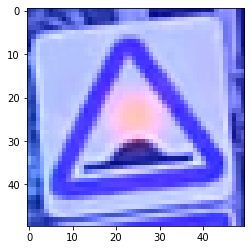

In [99]:
display_gradcam(8, model, 'bl10', 0.5)
plt.show()

There might be a few possible reasons:

1. Insufficient variations in training dataset
2. Activation location differs
3. There is visible camera distortion
4. Background is significantly different which means that the model isn't generalizing well.

Fine tune model by freezing layers and training head

#### Loaded model and attempt to freeze the layers and train the dense layers to improve the score.

In [100]:
trf_model = load_model('./saved_models/sgtraffic/sg_traffic_signs.h5')

In [101]:
opt = Adam(learning_rate=0.0005, amsgrad=True)

In [102]:
trf_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [103]:
for layer in trf_model.layers:
    if layer.name.startswith('bl'):
        layer.trainable = False

In [104]:
trf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 bl1 (Conv2D)                (None, 48, 48, 16)        448       
                                                                 
 bl2 (Conv2D)                (None, 46, 46, 32)        4640      
                                                                 
 bl3 (MaxPooling2D)          (None, 23, 23, 32)        0         
                                                                 
 bl4 (BatchNormalization)    (None, 23, 23, 32)        128       
                                                                 
 bl5 (Conv2D)                (None, 21, 21, 64)        18496     
                                                                 
 bl6 (Conv2D)                (None, 19, 19, 128)       73856 

In [105]:
model_train = trf_model.fit(aug.flow(X_train, y_train, batch_size=32), epochs=50, validation_data=(X_test, y_test), callbacks=[es])

Epoch 1/50
65/65 [==============================] - 11s 167ms/step - loss: 0.0374 - accuracy: 0.9908 - val_loss: 0.0632 - val_accuracy: 0.9842
Epoch 2/50
65/65 [==============================] - 11s 167ms/step - loss: 0.0202 - accuracy: 0.9927 - val_loss: 0.0460 - val_accuracy: 0.9876
Epoch 3/50
65/65 [==============================] - 10s 160ms/step - loss: 0.0503 - accuracy: 0.9879 - val_loss: 0.0839 - val_accuracy: 0.9808
Epoch 4/50
65/65 [==============================] - 11s 167ms/step - loss: 0.0455 - accuracy: 0.9869 - val_loss: 0.0609 - val_accuracy: 0.9864
Epoch 5/50
65/65 [==============================] - 11s 165ms/step - loss: 0.0274 - accuracy: 0.9903 - val_loss: 0.0507 - val_accuracy: 0.9864
Epoch 6/50
65/65 [==============================] - 11s 165ms/step - loss: 0.0201 - accuracy: 0.9932 - val_loss: 0.0533 - val_accuracy: 0.9853
Epoch 7/50
65/65 [==============================] - 11s 162ms/step - loss: 0.0224 - accuracy: 0.9927 - val_loss: 0.0446 - val_accuracy: 0.9887

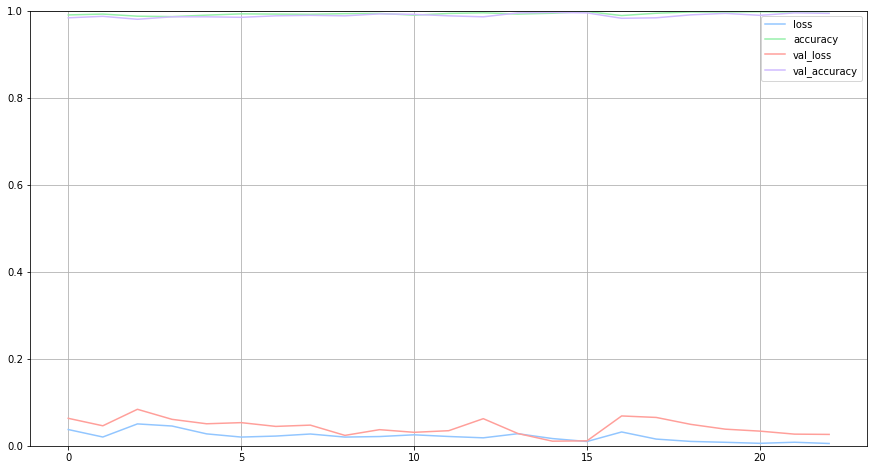

In [106]:
pd.DataFrame(model_train.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [107]:
pred = trf_model.predict(X_test1)
classes_x = np.argmax(pred, axis=1)

In [108]:
print(f'Test data accuracy {accuracy_score(labels, classes_x)*100}')

Test data accuracy 96.5909090909091


In [109]:
print(classification_report(labels, classes_x))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        11
           2       0.73      1.00      0.84         8
           3       0.92      0.92      0.92        12
           4       1.00      1.00      1.00         8
           5       1.00      0.90      0.95        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      0.80      0.89        15
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        12
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        14
          15       1.00      1.00      1.00        12
          16       0.92      1.00      0.96        11
          17       0.80    

In [111]:
trf_model.save('./saved_models/sgtraffic/finetuned/sg_traffic_signs.h5')

In [112]:
trf_model.save_weights('./saved_models/sgtraffic/finetuned/weights')

In [113]:
img_shuffle = random.sample(range(0, len(X_test)), 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


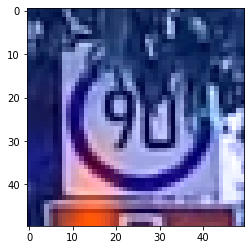

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


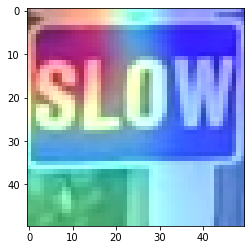

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


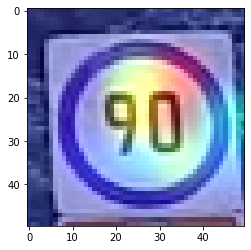

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


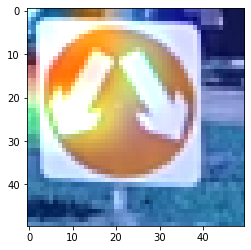

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


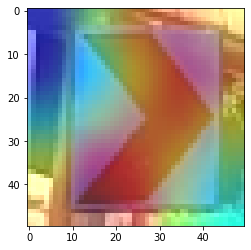

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


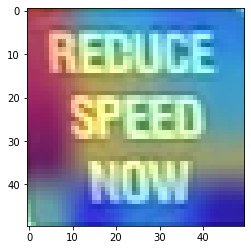

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


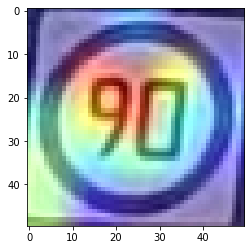

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


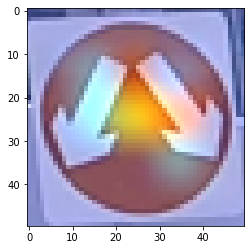

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


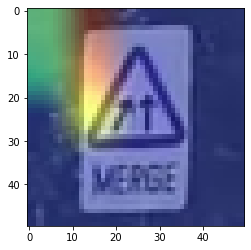

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


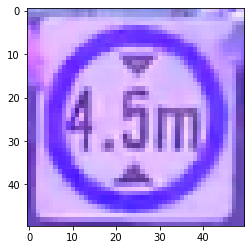

In [114]:
for i in img_shuffle:
    display_gradcam(i, model, 'bl10', 0.5)
    plt.show()

Bounding Box Regression

Built this function to parse the xml labelings

In [115]:
img_xml_dir_train = './sgtraffic_labelimg/bb_train/'
img_xml_dir_test = './sgtraffic_labelimg/bb_test/'

In [116]:
xtree = et.parse(img_xml_dir_train + '/' + '0272.xml')
xroot = xtree.getroot()

In [117]:
for node in xroot.findall('object'):
    values = [xroot.find('path').text,
              xroot.find('filename').text, # filename
              xroot.find("size")[0].text, # width
              xroot.find("size")[1].text, # height
              node[0].text, # name/class
              node[4][0].text, # xmin
              node[4][1].text, # ymin
              node[4][2].text, # xmax
              node[4][3].text] # ymax

In [118]:
values

['C:\\GA\\capstone\\objdetect\\sgtraffic_labelimg\\Train\\1\\0272.jpg',
 '0272.jpg',
 '71',
 '71',
 '1',
 '4',
 '3',
 '67',
 '66']

In [119]:
def xml_append_df(path):
  xml_list = []
  try:
    for xml_file in glob.glob(path + '*.xml'):
      xtree = et.parse(xml_file)
      xroot = xtree.getroot()
      for node in xroot.findall('object'):
        values = [xroot.find('path').text, # path
                  xroot.find('filename').text, # filename
                  xroot.find("size")[0].text, # width
                  xroot.find("size")[1].text, # height
                  node[0].text, # name/class
                  node[4][0].text, # xmin
                  node[4][1].text, # ymin
                  node[4][2].text, # xmax
                  node[4][3].text # ymax
                  ]
        xml_list.append(values)
  except:
        print(f'unable to append {xml_file}')

  col_name = ['path', 'filename', 'width', 'height', 'class_name', 'xmin', 'ymin', 'xmax', 'ymax']
  xml_df = pd.DataFrame(xml_list, columns=col_name)
  return xml_df

In [120]:
train_xml_df = xml_append_df(img_xml_dir_train)

In [121]:
test_xml_df = xml_append_df(img_xml_dir_test)

In [122]:
train_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0059.jpg,63,63,8,8,9,58,58
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0063.jpg,111,114,8,12,13,100,100
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0065.jpg,159,189,8,20,20,139,164
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0163.jpg,99,99,8,18,11,81,90
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0167.jpg,60,60,10,16,16,47,44
...,...,...,...,...,...,...,...,...,...
1475,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,6544.JPG,111,166,7,24,25,85,144
1476,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,6675.JPG,228,169,0,16,19,149,161
1477,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,7654.JPG,151,159,10,39,41,111,114
1478,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,7877.JPG,134,143,7,31,21,113,128


In [123]:
test_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0283.jpg,48,48,1,4,2,46,44
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0356.jpg,42,42,0,4,3,40,39
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0397.jpg,51,51,1,4,4,44,46
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0553.jpg,80,80,7,12,7,65,73
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0601.jpg,76,76,3,3,4,74,74
...,...,...,...,...,...,...,...,...,...
98,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5623.jpg,177,177,14,14,67,165,114
99,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5644.jpg,148,148,14,11,50,126,98
100,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5920.jpg,152,152,3,20,24,141,144
101,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5968.jpg,252,252,3,30,37,239,231


In [124]:
class_dist = train_xml_df.groupby('class_name').count().reset_index()[['class_name', 'filename']]

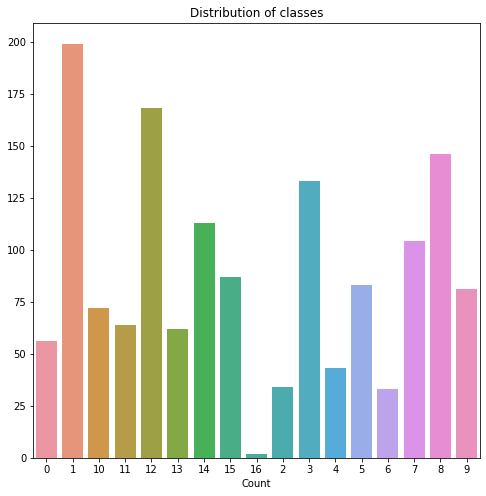

In [125]:
plt.figure(figsize=(8, 8))
sns.barplot(x=class_dist['class_name'], y=class_dist['filename'])
plt.title('Distribution of classes')
plt.ylabel('')
plt.xlabel('Count')
plt.show()

In [126]:
train_xml_df['path'][0]

'C:\\GA\\capstone\\objdetect\\sgtraffic_labelimg\\Train\\8\\0059.jpg'

In [127]:
groundtruth_df = train_xml_df[train_xml_df['filename'] == '0272.jpg']

In [128]:
groundtruth_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
22,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0272.jpg,71,71,1,4,3,67,66


In [129]:
draw = cv2.imread(groundtruth_df['path'].iloc[0])

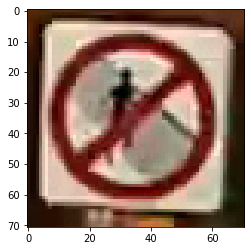

In [130]:
plt.imshow(cv2.cvtColor(draw, cv2.COLOR_BGR2RGB));

In [131]:
groundtruth_df['xmin'].iloc[0]

'4'

In [132]:
start_pt = (int(groundtruth_df['xmin'].iloc[0]), int(groundtruth_df['ymin'].iloc[0]))
end_pt = (int(groundtruth_df['xmax'].iloc[0]), int(groundtruth_df['ymax'].iloc[0]))

In [133]:
color = (255, 0, 0)
thickness = 2

In [134]:
img_groundtruth = cv2.rectangle(draw, start_pt, end_pt, color, thickness)

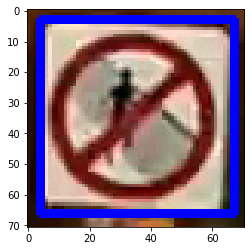

In [135]:
plt.imshow(cv2.cvtColor(img_groundtruth, cv2.COLOR_BGR2RGB));

Define training images

In [136]:
training_img = train_xml_df[['path']]

In [137]:
training_img

,path
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
...,...
1475,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1476,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1477,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...
1478,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...


In [138]:
train_images = []
train_targets = []
train_labels = []

In [139]:
for index, row in train_xml_df.iterrows():
    (path, filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    train_img_fullpath = path

    xmin = round(int(xmin)/int(width), 2)
    ymin = round(int(ymin)/int(height), 2)
    xmax = round(int(xmax)/int(width), 2)
    ymax = round(int(ymax)/int(height), 2)

    height = img_ht
    width = img_wd

    train_img = keras.preprocessing.image.load_img(train_img_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    train_img_arr = train_img_arr / 255

    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(int(class_name))

In [140]:
print(f'train_images = {len(train_images)}, train_targets = {len(train_targets)}, train_labels = {len(train_labels)}')

train_images = 1480, train_targets = 1480, train_labels = 1480


In [141]:
train_images_arr = np.array(train_images, dtype=float)
train_targets_arr = np.array(train_targets, dtype=float)
train_labels_arr = np.array(train_labels, dtype=float)

## Test Dataset

In [142]:
test_images = []
test_targets = []
test_labels = []
test_area = []

In [143]:
classes_list = list(test_xml_df['class_name'].unique())
classes_list

['1', '0', '7', '3', '14', '15', '9', '2', '13', '10', '8', '12', '11']

In [144]:
test_xml_df

,path,filename,width,height,class_name,xmin,ymin,xmax,ymax
0,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0283.jpg,48,48,1,4,2,46,44
1,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0356.jpg,42,42,0,4,3,40,39
2,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0397.jpg,51,51,1,4,4,44,46
3,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0553.jpg,80,80,7,12,7,65,73
4,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,0601.jpg,76,76,3,3,4,74,74
...,...,...,...,...,...,...,...,...,...
98,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5623.jpg,177,177,14,14,67,165,114
99,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5644.jpg,148,148,14,11,50,126,98
100,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5920.jpg,152,152,3,20,24,141,144
101,C:\GA\capstone\objdetect\sgtraffic_labelimg\Tr...,5968.jpg,252,252,3,30,37,239,231


In [145]:
test_xml_df['xmin'] = test_xml_df['xmin'].astype(int)
test_xml_df['ymin'] = test_xml_df['ymin'].astype(int)
test_xml_df['xmax'] = test_xml_df['xmax'].astype(int)
test_xml_df['ymax'] = test_xml_df['ymax'].astype(int)

In [146]:
test_xml_df['area'] = (test_xml_df['xmax'] - test_xml_df['xmin']) * (test_xml_df['ymax'] - test_xml_df['ymin'])

In [147]:
for index, row in test_xml_df.iterrows():
    (path, filename, width, height, class_name, xmin, ymin, xmax, ymax, area) = row
    test_img_fullpath = path

    xmin = round(int(xmin)/int(width), 2)
    ymin = round(int(ymin)/int(height), 2)
    xmax = round(int(xmax)/int(width), 2)
    ymax = round(int(ymax)/int(height), 2)

    height = img_ht
    width = img_wd

    test_img = keras.preprocessing.image.load_img(test_img_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)
    test_img_arr = test_img_arr / 255

    test_area.append(area)
    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(int(class_name))

In [149]:
print(f'test_images = {len(test_images)}, test_targets = {len(test_targets)}, test_labels = {len(test_labels)}')

test_images = 103, test_targets = 103, test_labels = 103


In [150]:
test_images_arr = np.array(test_images, dtype=float)
test_targets_arr = np.array(test_targets, dtype=float)
test_labels_arr = np.array(test_labels, dtype=float)

Modeling

In [151]:
locator_model = load_model('./saved_models/sgtraffic/finetuned/sg_traffic_signs.h5')

In [152]:
opt = Adam(learning_rate=0.001, amsgrad=True)

In [153]:
locator_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [154]:
for layer in locator_model.layers:
    if layer.name.startswith('bl'):
        layer.trainable = False

for layer in locator_model.layers:
    if layer.name.startswith('cl'):
        layer.trainable = False

In [155]:
locator_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 bl1 (Conv2D)                (None, 48, 48, 16)        448       
                                                                 
 bl2 (Conv2D)                (None, 46, 46, 32)        4640      
                                                                 
 bl3 (MaxPooling2D)          (None, 23, 23, 32)        0         
                                                                 
 bl4 (BatchNormalization)    (None, 23, 23, 32)        128       
                                                                 
 bl5 (Conv2D)                (None, 21, 21, 64)        18496     
                                                                 
 bl6 (Conv2D)                (None, 19, 19, 128)       73856 

In [156]:
locator_branch = keras.layers.Dense(1024, activation='relu', name='bb1')(bl)
locator_branch = keras.layers.Dense(532, activation='relu', name='bb2')(locator_branch)
locator_branch = keras.layers.Dense(256, activation='relu', name='bb3')(locator_branch)
locator_branch = keras.layers.Dense(128, activation='relu', name='bb4')(locator_branch)
locator_branch = keras.layers.Dense(64, activation='relu', name='bb5')(locator_branch)
locator_branch = keras.layers.Dense(32, activation='relu', name='bb6')(locator_branch)
locator_branch = keras.layers.Dropout(rate=0.1, name='bb7')(locator_branch)

locator_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [157]:
locator_model = tf.keras.Model(input_layer, outputs = [classifier_branch, locator_branch])

In [158]:
locator_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 50, 3)]  0           []                               
                                                                                                  
 bl1 (Conv2D)                   (None, 48, 48, 16)   448         ['input_1[0][0]']                
                                                                                                  
 bl2 (Conv2D)                   (None, 46, 46, 32)   4640        ['bl1[0][0]']                    
                                                                                                  
 bl3 (MaxPooling2D)             (None, 23, 23, 32)   0           ['bl2[0][0]']                    
                                                                                           

In [159]:
opt = Adam(learning_rate=0.001, amsgrad=True)

In [160]:
losses = {
    "cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    "bb_head":tf.keras.losses.MSE
   }

In [161]:
locator_model.compile(loss=losses, optimizer=opt, metrics=['accuracy'])

In [162]:
trainTargets = {
    "cl_head": train_labels_arr,
    "bb_head": train_targets_arr
}
validationTargets = {
    "cl_head": test_labels_arr,
    "bb_head": test_targets_arr
}

In [163]:
es = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True, mode='auto', verbose=1)

In [164]:
# aug = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=0.15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.15,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode="nearest")

In [165]:
dual_history = locator_model.fit(train_images_arr, trainTargets,
                                 validation_data = (test_images_arr,
                                                    validationTargets),
                                 batch_size = 32,
                                 epochs = 200,
                                 callbacks=[es])

Epoch 1/200


"`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"


47/47 [==============================] - 8s 158ms/step - loss: 0.2200 - cl_head_loss: 0.1940 - bb_head_loss: 0.0261 - cl_head_accuracy: 0.9649 - bb_head_accuracy: 0.4973 - val_loss: 0.1998 - val_cl_head_loss: 0.1832 - val_bb_head_loss: 0.0166 - val_cl_head_accuracy: 0.9709 - val_bb_head_accuracy: 0.5437
Epoch 2/200
47/47 [==============================] - 7s 149ms/step - loss: 0.1012 - cl_head_loss: 0.0911 - bb_head_loss: 0.0101 - cl_head_accuracy: 0.9878 - bb_head_accuracy: 0.6791 - val_loss: 0.1220 - val_cl_head_loss: 0.1180 - val_bb_head_loss: 0.0040 - val_cl_head_accuracy: 0.9515 - val_bb_head_accuracy: 0.7864
Epoch 3/200
47/47 [==============================] - 7s 150ms/step - loss: 0.1036 - cl_head_loss: 0.0984 - bb_head_loss: 0.0052 - cl_head_accuracy: 0.9818 - bb_head_accuracy: 0.7216 - val_loss: 1.9535 - val_cl_head_loss: 1.9449 - val_bb_head_loss: 0.0087 - val_cl_head_accuracy: 0.7864 - val_bb_head_accuracy: 0.7961
Epoch 4/200
47/47 [==============================] - 7s 149ms

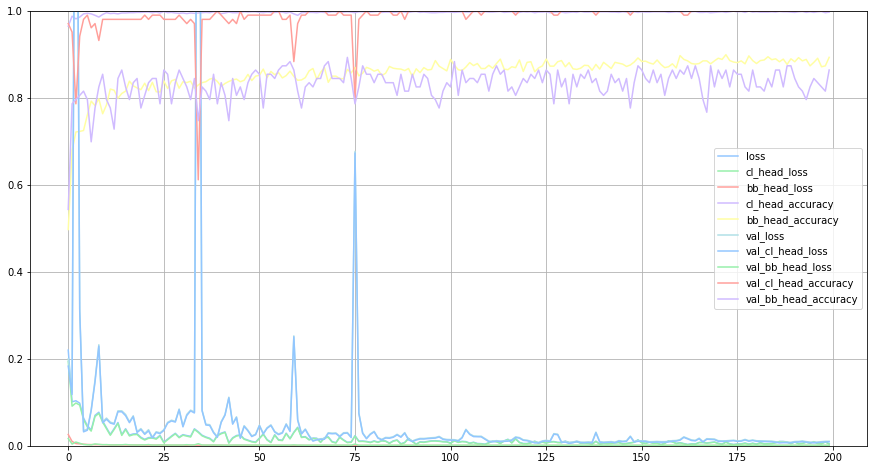

In [166]:
pd.DataFrame(dual_history.history).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [167]:
loc_pred = locator_model.predict(test_images_arr)

In [168]:
classes_xtest = np.argmax(loc_pred[0], axis=1)

In [169]:
test_labels_arr

array([ 1.,  0.,  1.,  7.,  3.,  1., 14., 14., 14., 14., 14., 15., 15.,
        1.,  9.,  9.,  0.,  2.,  3., 13., 13.,  3., 13.,  3., 10., 10.,
       10., 10., 10.,  8.,  0., 13., 15.,  1.,  1.,  3.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  1.,  1.,  8., 10.,  1., 15.,  1.,  1.,  1.,
        1.,  9.,  9.,  9.,  9., 15.,  1.,  1.,  1., 10.,  8.,  1.,  2.,
        8.,  0.,  0.,  0.,  8., 12., 12., 12., 12., 12.,  1., 11., 11.,
        1.,  7.,  1.,  1.,  1., 13., 14.,  3., 13., 13.,  0.,  0.,  3.,
       13., 13., 13., 13., 13., 13., 14., 14., 14.,  3.,  3.,  0.])

In [170]:
classes_xtest

array([ 1,  0,  1,  7,  3,  1, 14, 14, 14, 14, 14, 15, 15,  1,  9,  9,  0,
        2,  3, 13, 13,  3, 13,  3, 10, 10, 10, 10, 10,  8,  0, 13, 15,  1,
        1,  3,  0,  0,  0,  1,  1,  1,  1,  1,  1,  8, 10,  1, 15,  1,  1,
        1,  1,  9,  9,  9,  9, 15,  1,  1,  1, 10,  8,  1,  2,  8,  0,  0,
        0,  8, 12, 12, 12, 12, 12,  1, 11, 11,  1,  7,  1,  1,  1, 13, 14,
        3, 13, 13,  0,  0,  3, 13, 13, 13, 13, 13, 13, 14, 14, 14,  3,  3,
        0], dtype=int64)

In [171]:
print(classification_report(test_labels_arr, classes_xtest))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        12
         1.0       1.00      1.00      1.00        26
         2.0       1.00      1.00      1.00         2
         3.0       1.00      1.00      1.00         9
         7.0       1.00      1.00      1.00         2
         8.0       1.00      1.00      1.00         5
         9.0       1.00      1.00      1.00         6
        10.0       1.00      1.00      1.00         7
        11.0       1.00      1.00      1.00         2
        12.0       1.00      1.00      1.00         5
        13.0       1.00      1.00      1.00        13
        14.0       1.00      1.00      1.00         9
        15.0       1.00      1.00      1.00         5

    accuracy                           1.00       103
   macro avg       1.00      1.00      1.00       103
weighted avg       1.00      1.00      1.00       103



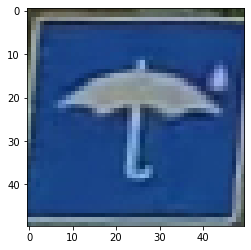

In [172]:
plt.imshow(test_images_arr[20])

In [173]:
def IOU(gt_bb, pred_bb, num, width, height):
    gt_xmin, gt_ymin, gt_xmax, gt_ymax = (gt_bb[num][0] * width), (gt_bb[num][1] * height), (gt_bb[num][2] * width), (gt_bb[num][3] * height)
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = (pred_bb[1][num][0] * width), (pred_bb[1][num][1] * height), (pred_bb[1][num][2] * width), (pred_bb[1][num][3] * height)
    x_inter1 = max(gt_xmin, pred_xmin)
    y_inter1 = max(gt_ymin, pred_ymin)
    x_inter2 = min(gt_xmax, pred_xmax)
    y_inter2 = min(gt_ymax, pred_ymax)
    width_inter = abs(x_inter2 - x_inter1)
    height_inter = abs(y_inter2 - y_inter1)
    area_inter = width_inter * height_inter
    width_box1 = abs(gt_xmax - gt_xmin)
    height_box1 = abs(gt_ymax - gt_ymin)
    width_box2 = abs(pred_xmax - pred_xmin)
    height_box2 = abs(pred_ymax - pred_ymin)
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    area_union = area_box1 + area_box2 - area_inter
    iou = area_inter / area_union
    return iou

In [174]:
def bb_box(img, num, color, thickness, width, height):
    start_pt = (int(loc_pred[1][num][0] * width), int(loc_pred[1][num][1] * height))
    end_pt = (int(loc_pred[1][num][2] * width), int(loc_pred[1][num][3] * height))

    st_pt = (int(test_targets_arr[num][0] * width), int(test_targets_arr[num][1] * height))
    e_pt = (int(test_targets_arr[num][2] * width), int(test_targets_arr[num][3] * height))

    img_gt = cv2.rectangle(img[num], st_pt, e_pt, (0, 0, 255), thickness)
    img_bb = cv2.rectangle(img[num], start_pt, end_pt, color, thickness)

    iou_img = round((IOU(test_targets_arr, loc_pred, num, img_ht, img_wd)), 2)
    classes_xtest = np.argmax(loc_pred[0], axis=1)
    plt.xlabel(f'Actual={int(test_labels_arr[num])} || Pred={classes_xtest[num]} || IOU={iou_img}', color= 'g')
    plt.imshow(img_bb)
    plt.savefig(f'./imgs/classlocalize/{num}_{num}.png', dpi=400)
    return plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


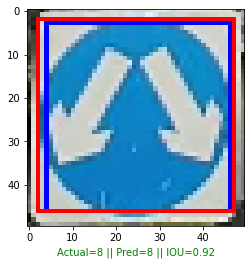

In [175]:
bb_box(test_images_arr, 45, (100, 0, 0), 1, img_ht, img_wd)

In [176]:
img_shuffle = random.sample(range(0, len(test_images_arr)), len(test_images_arr))

In [177]:
gt_area = []
pred_area = []
iou_list = []

In [178]:
pred_area_df = pd.DataFrame(list(loc_pred[1]), columns=['pred_xmin', 'pred_ymin', 'pred_xmax', 'pred_ymax'])

Previously defined height = 50, width = 50

In [179]:
pred_area_df['pred_xmin'] = pred_area_df['pred_xmin'] * width
pred_area_df['pred_ymin'] = pred_area_df['pred_ymin'] * height
pred_area_df['pred_xmax'] = pred_area_df['pred_xmax'] * width
pred_area_df['pred_ymax'] = pred_area_df['pred_ymax'] * height

pred_area_df['area'] = abs((pred_area_df['pred_xmax'] - pred_area_df['pred_xmin']) * (pred_area_df['pred_ymax'] - pred_area_df['pred_ymin']))

In [180]:
for ar in img_shuffle:
    gt_area.append(test_area[ar])
    pred_area.append(pred_area_df['area'].iloc[ar])
    iou_list.append(round((IOU(test_targets_arr, loc_pred, ar, img_ht, img_wd)), 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


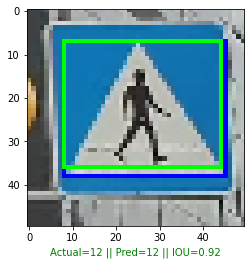

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


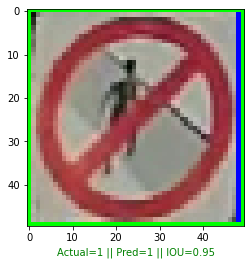

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


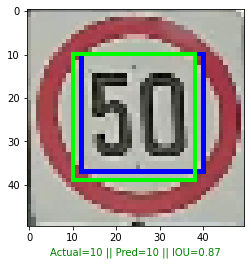

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


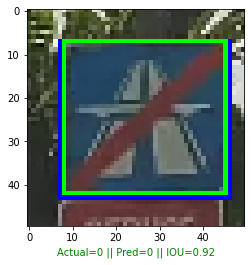

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


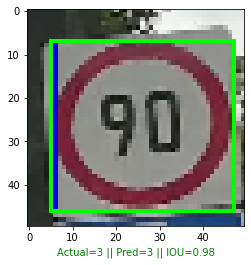

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


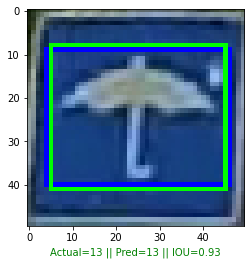

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


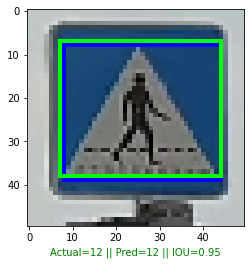

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


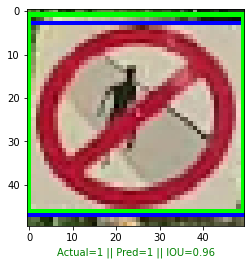

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


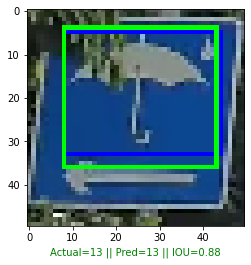

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


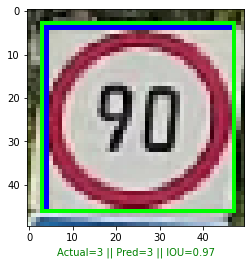

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


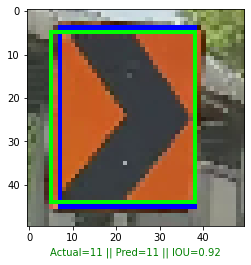

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


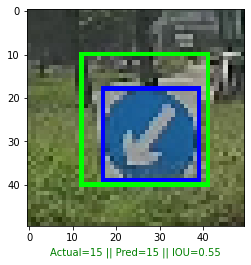

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


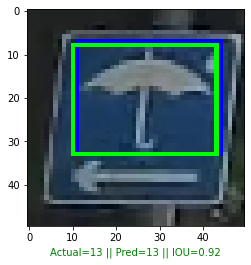

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


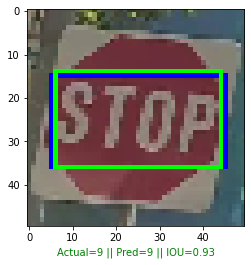

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


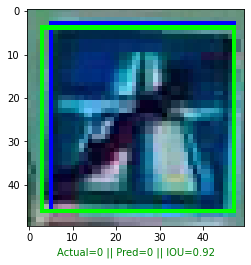

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


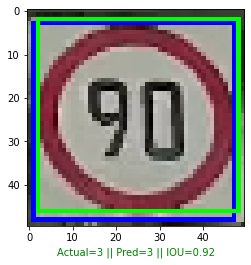

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


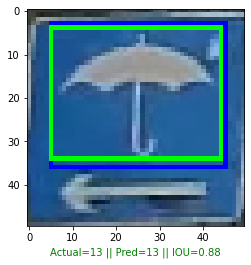

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


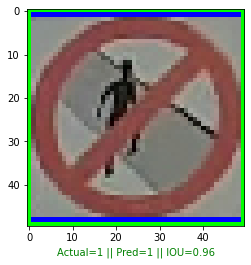

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


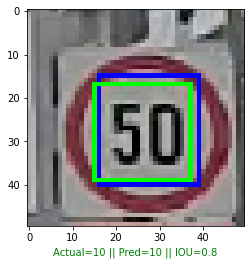

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


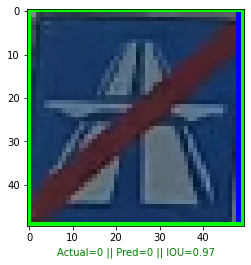

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


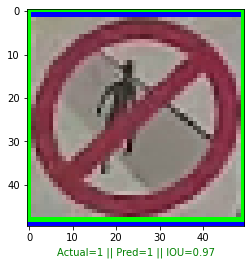

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


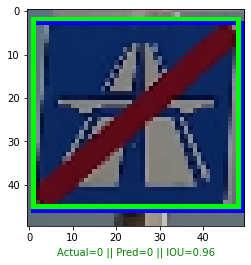

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


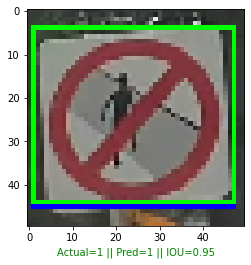

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


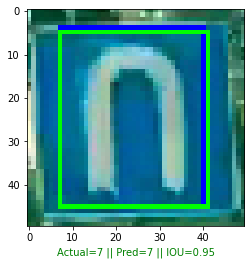

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


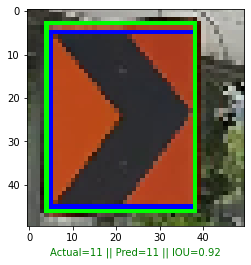

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


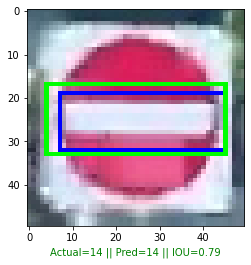

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


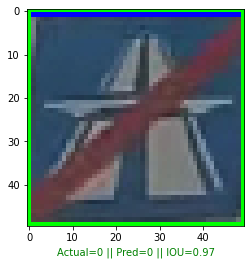

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


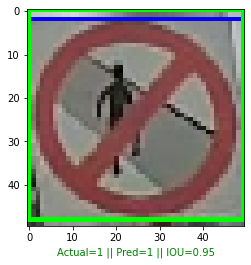

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


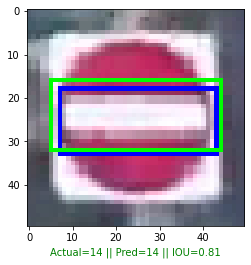

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


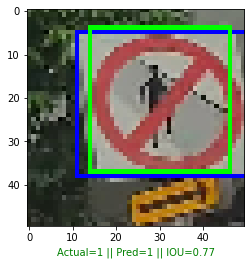

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


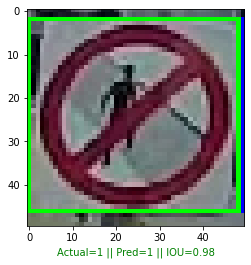

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


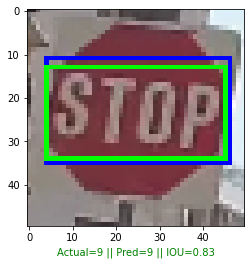

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


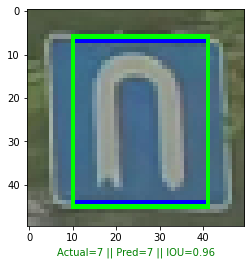

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


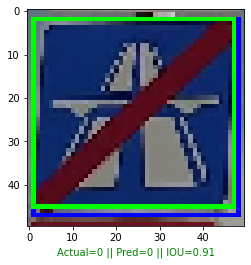

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


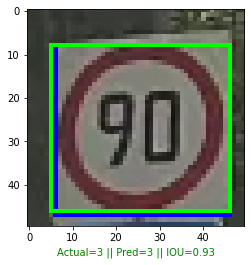

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


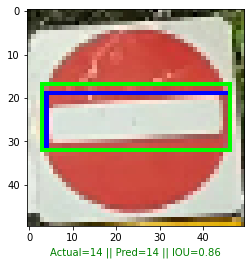

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


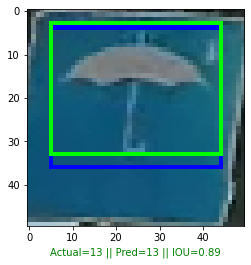

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


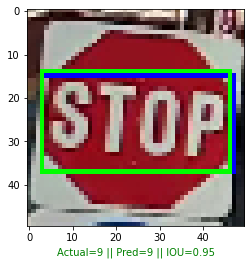

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


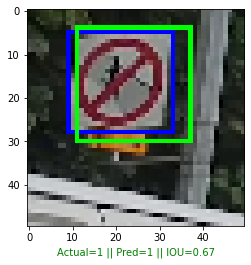

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


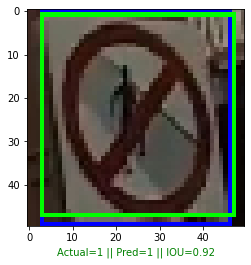

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


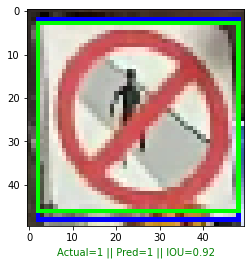

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


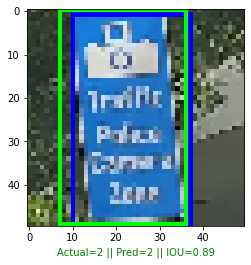

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


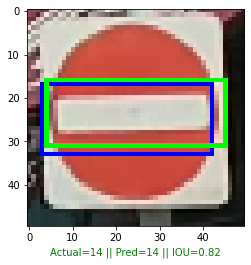

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


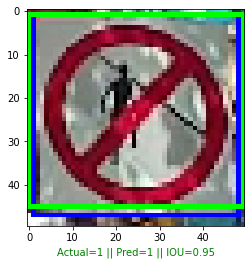

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


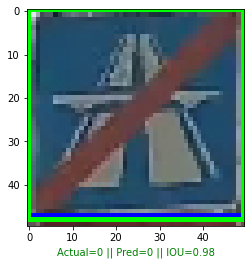

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


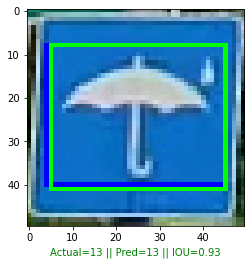

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


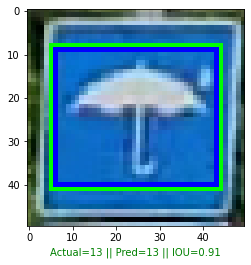

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


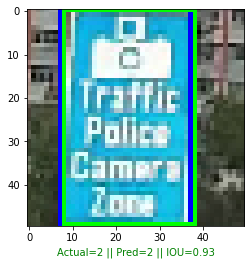

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


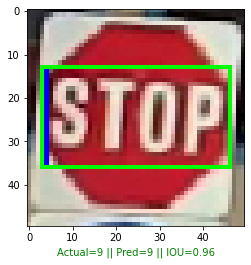

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


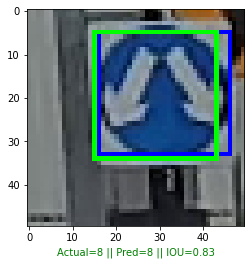

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


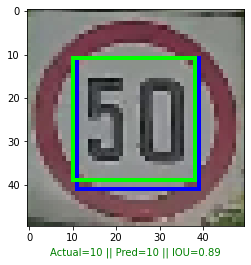

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


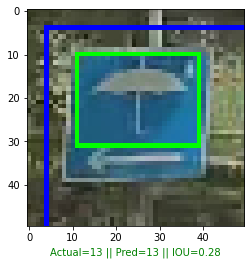

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


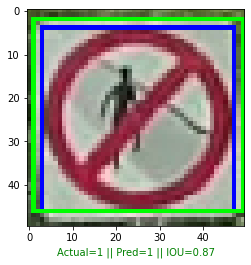

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


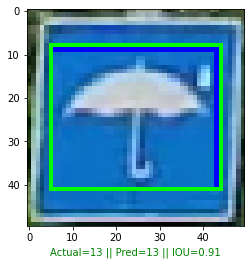

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


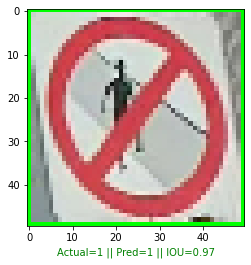

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


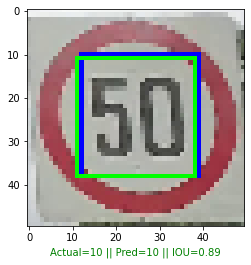

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


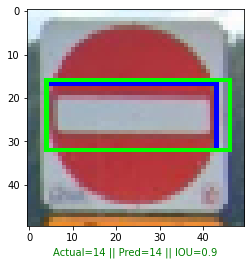

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


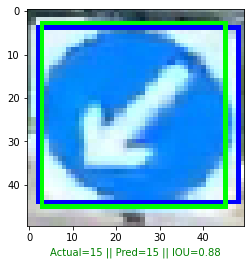

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


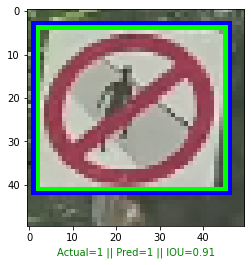

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


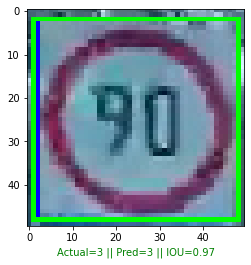

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


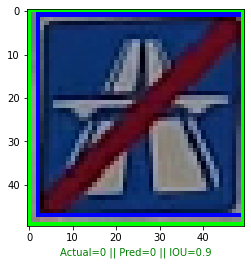

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


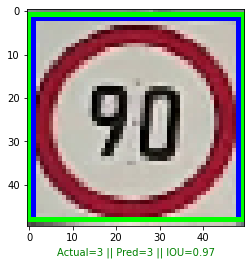

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


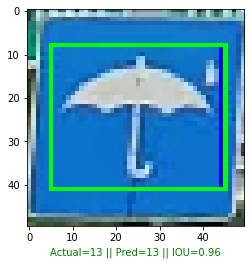

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


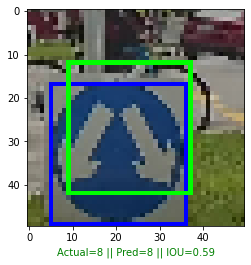

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


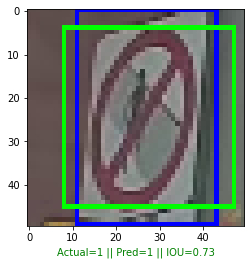

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


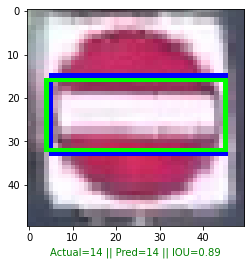

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


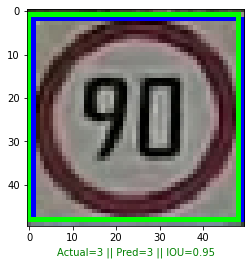

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


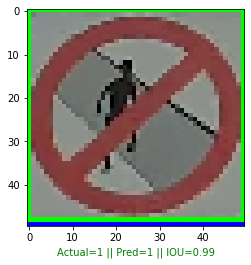

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


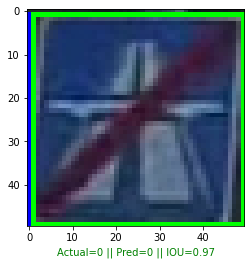

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


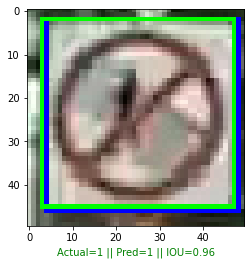

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


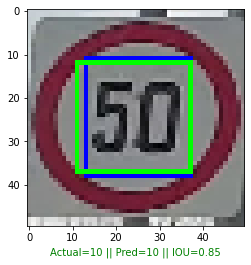

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


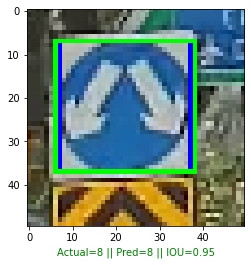

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


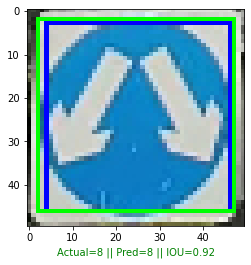

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


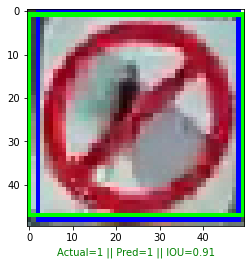

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


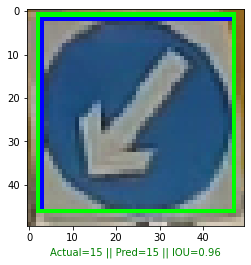

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


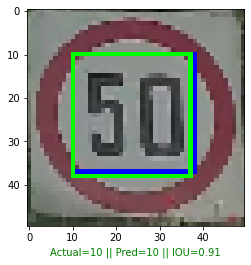

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


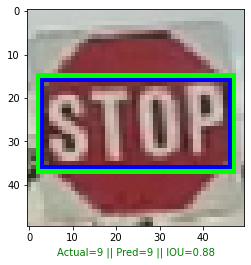

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


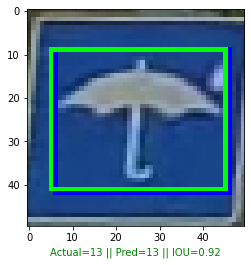

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


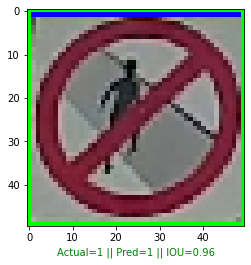

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


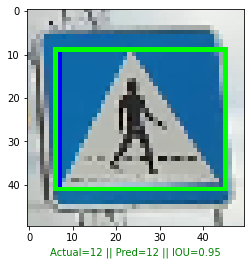

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


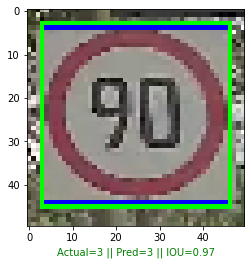

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


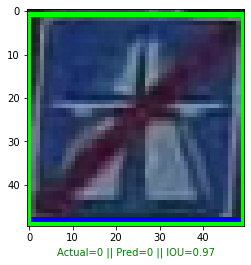

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


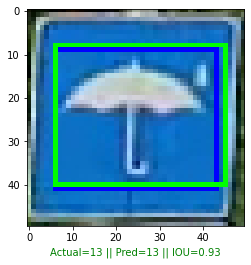

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


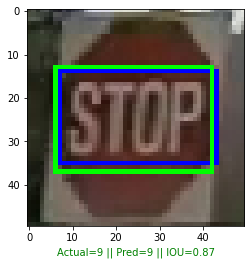

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


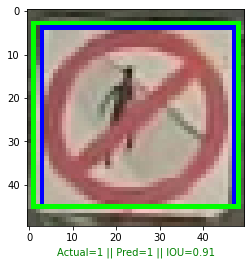

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


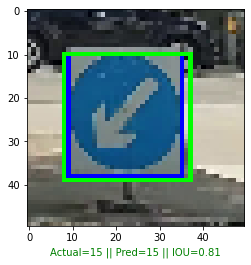

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


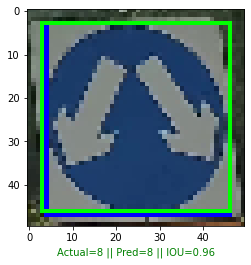

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


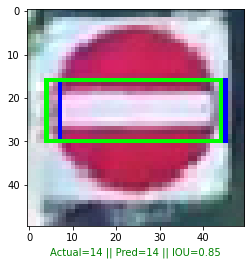

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


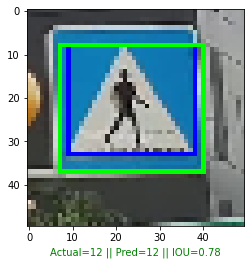

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


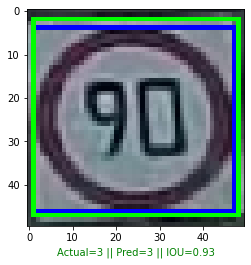

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


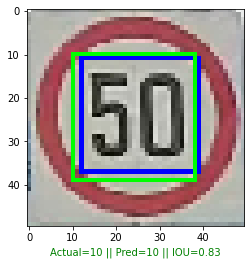

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


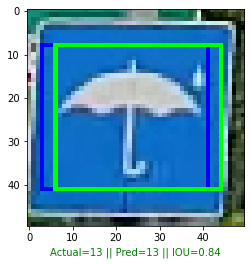

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


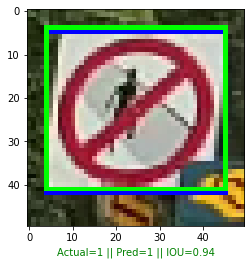

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


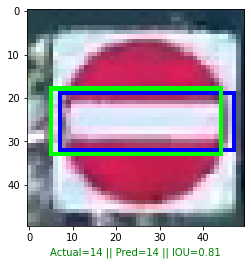

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


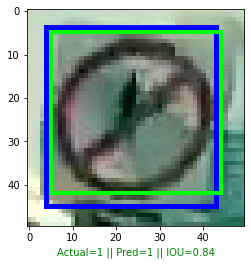

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


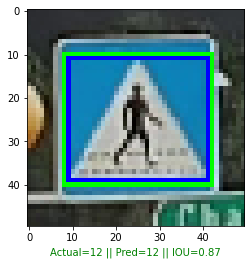

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


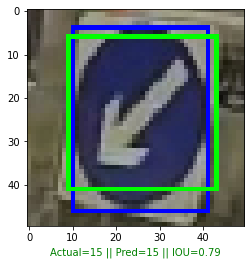

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


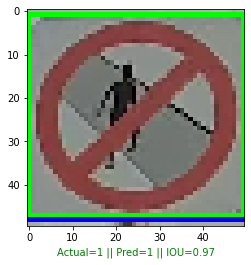

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


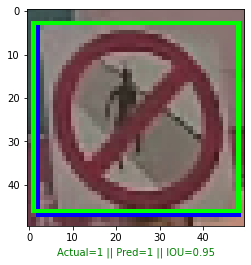

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


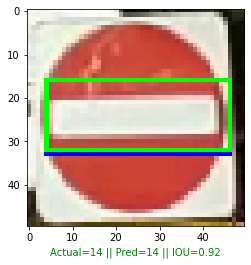

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


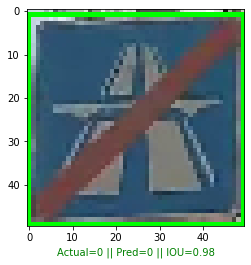

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


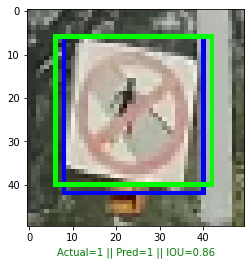

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


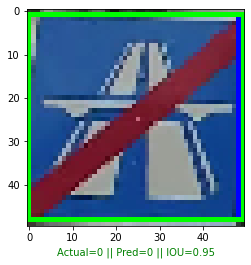

In [181]:
for i in img_shuffle:
    bb_box(test_images_arr, i, (0, 255, 0), 1, img_ht, img_wd)

# IoU as metric for predicted bounding boxes.

In [182]:
iou_score = round((sum(iou_list) / len(iou_list)), 2)

In [183]:
print(f'The IoU accuracy of {len(iou_list)} predicted bounding boxes is {iou_score}.')

The IoU accuracy of 103 predicted bounding boxes is 0.9.


In [184]:
locator_model.save('./saved_models/final/sgtrafficloc/sg_traffic_loc.h5')

In [185]:
locator_model.save_weights('./saved_models/final/sgtrafficloc/weights')

Convert to TFLite for deployment to Raspberry Pi (Future works)

In [186]:
converter = tf.lite.TFLiteConverter.from_keras_model(locator_model)
tfl_locator = converter.convert()

with open('locator.tflite', 'wb') as f:
    f.write(tfl_locator)

INFO:tensorflow:Assets written to: C:\Users\thien\AppData\Local\Temp\tmp9hteptjg\assets


In [187]:
## End of part 3 - object localization